# Импорты 

Код требует библиотеки numpy и scipy для математики и массивов, pyscf для вычисления интегралов

In [1]:
import numpy as np
import scipy as sp
from pyscf import gto, scf, ao2mo
from functools import reduce
import matplotlib.pyplot as plt

# Создаем объект молекулы

Задаем набор атомных координат, спин, базисный набор.

## О базисных наборах

Базовый набор в теоретической и вычислительной химии - это набор функций (называемых базисными функциями), которые объединяются в линейные комбинации (обычно как часть квантово-химических расчетов) для создания молекулярных орбиталей. Для удобства эти функции обычно представляют собой атомные орбитали с центром на атомах, но теоретически могут быть любой функцией; плоские волны часто используются при расчетах материалов.

Чтобы описать электронные состояния молекул, мы строим волновые функции для электронных состояний, используя молекулярные орбитали. Эти волновые функции являются приближенными решениями уравнения Шредингера. Математическая функция для молекулярной орбитали строится, ψi, как линейная комбинация других функций, φj, которые называются базисными функциями, потому что они обеспечивают основу для представления молекулярной орбитали.

$$\psi_i = \sum \limits_j c_{ij} \phi_{j} $$

Очевидный вариант базисного набора - функции соответствующие точным решениям водородоподобного атома. Они имеют вид
$$\phi^{STO} = \alpha e ^{-\beta (r-r_0)}$$
называются Слейтеровыми орбиталями и выглядят вот так:

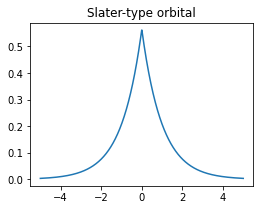

In [2]:
x = np.linspace(-5,5,num=1000)
r = abs(x)

zeta = 1.0

psi_STO = (zeta**3/np.pi)**(0.5)*np.exp(-zeta*r)

plt.figure(figsize=(4,3))
plt.title("Slater-type orbital")
plt.plot(x,psi_STO)

Орбитали слейтеровского типа (STO) являются точными решениями для атома водорода и обеспечивают точный базис для многоэлектронных молекул, однако вычисления интегралов дороги, поскольку они не являются простым точным решением для интегралов. Один из способов обойти это - аппроксимировать орбитали типа Слейтера, используя сумму контрактированных функций Гаусса (CGF). Существуют простые аналитические выражения для интегралов между двумя гауссианами, так что это может сэкономить много времени вычислений. Давайте посмотрим на это для случая 1s-орбитали:

$$\phi^{GF}(\alpha)=(2\alpha/\pi)^{3/4}exp(-\alpha r^{2})$$
$$\phi^{CGF}\left( \boldsymbol{r}\right) = \sum_n d_n\phi^{GF}_n(\alpha)$$

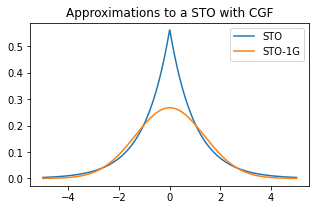

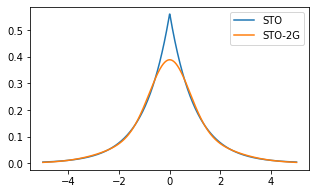

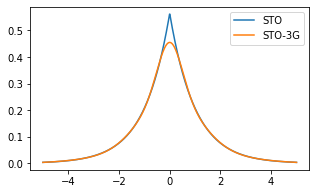

In [3]:
# Coefficients for STO_3G basis set
Coeff = np.array([[1.00000,0.0000000,0.000000],
                  [0.678914,0.430129,0.000000],
                  [0.444635,0.535328,0.154329]])
# Exponents for STO-3G basis set
Expon = np.array([[0.270950,0.000000,0.000000],
                  [0.151623,0.851819,0.000000],
                  [0.109818,0.405771,2.227660]]) 

psi_CGF_STO1G = Coeff[0,0]*(2*Expon[0,0]/np.pi)**(0.75)*np.exp(-Expon[0,0]*r**2)
psi_CGF_STO2G = Coeff[1,0]*(2*Expon[1,0]/np.pi)**(0.75)*np.exp(-Expon[1,0]*r**2) \
                + Coeff[1,1]*(2*Expon[1,1]/np.pi)**(0.75)*np.exp(-Expon[1,1]*r**2) \
                + Coeff[1,2]*(2*Expon[1,2]/np.pi)**(0.75)*np.exp(-Expon[1,2]*r**2)
psi_CGF_STO3G = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r**2)
    
# Plot the three functions
plt.figure(figsize=(5,3))
plt.title("Approximations to a STO with CGF")
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO1G,label="STO-1G")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO2G,label="STO-2G")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO3G,label="STO-3G")
plt.legend()


In [4]:
# create Mol object
mol = gto.M()
mol.atom =("""
 H 0 1.7 0
 H 0 0 0
 """)

# set spin and basis set
mol.spin = 0
mol.basis = 'sto-3g'
mol.build()

Считаем число электронов с каждым спином

In [5]:
# number of AOs
Norb = mol.nao_nr()

#UHF convergent criteria
e_conv = 1.e-7
d_conv = 1.e-7

if (mol.nelectron %2 != 0):
	nel_a = int(0.5 * (mol.nelectron + 1))
	nel_b = int(0.5 * (mol.nelectron - 1))
else:
	nel_a = int(0.5 * mol.nelectron)
	nel_b = nel_a


# Интегралы

Расчет интегралов - наиболее сложная часть метода Хартри-Фока. Их мы посчитаем с помощью программы PySCF, так как питоновский код тут не даст достаточной производительности, и даже cython, с декларациями типов и по возможности избавлением от GIL не помогает исправлению ситуации.

### О теории, лежащей под HF:

Мы решаем уравнение Шредингера:

$$H \psi = E\psi$$

Гамильтониан в нашем случае такой:

$$\left[ -\sum_i \frac{\nabla_i^{2}}{2} -\sum_A \frac{\nabla_A^{2}}{2} - \sum_{A,i}\frac{Z_{A}}{r_{Ai}}+\sum_{A>B}\frac{Z_A Z_B}{R_{AB}}+\sum_{i>j}\frac{1}{r_{ij}}\right]\Psi(\boldsymbol{r};\boldsymbol{R})=E\Psi(\boldsymbol{r};\boldsymbol{R})$$

Рассмотрим члены по отдельности:

- Кинетическая энергия электронов:

$$\hat{T}_e(\boldsymbol{r})=-\sum_i \frac{\nabla_i^{2}}{2}$$

- Кинетическая энергия ядер:

$$\hat{T}_N(\boldsymbol{R})=-\sum_A \frac{\nabla_A^{2}}{2}$$

- Кулоновское притяжение ядер с электронами:

$$\hat{V} _{eN}(\boldsymbol{r};\boldsymbol{R})= - \sum_{A,i}\frac{Z_{A}}{r_{Ai}}$$

- Ядерное отталкивание

$$\hat{V}_{NN}(\boldsymbol{R})=+\sum_{A>B}\frac{Z_A Z_B}{R_{AB}}$$

- Электронное отталкивание

$$\hat{V}_{ee}(\boldsymbol{r})=+\sum_{i>j}\frac{1}{r_{ij}}$$

### Нужные нам интегралы:


- Overlap s

$$S_{\mu \nu} = \int \phi_\mu (\boldsymbol{r}) \phi_\nu (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}$$

- Kinetic Integral $T$

$$T_{\mu \nu} = \int \phi_\mu (\boldsymbol{r}) \left( - \frac{1}{2} \nabla_{\boldsymbol{r}}^2 \right) \phi_\nu (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}$$

- Nuclear-Attraction Integral $V$

$$V_{\mu \nu} = \int \phi_\mu (\boldsymbol{r}) \left( - \sum_A \frac{Z_A}{|\boldsymbol{r} - \boldsymbol{R}_A|} \right) \phi_\nu (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}$$

- Собираем core Hamiltonian:

$$H_{\mu \nu}^\mathrm{core} = T_{\mu \nu} + V_{\mu \nu}$$

- Двухэлектронные интегралы

Самая дорогая часть - $O(n^4)$

$$(\mu \nu | \kappa \lambda) = \int \phi_\mu (\boldsymbol{r}_1) \phi_\nu (\boldsymbol{r}_1) \frac{1}{|\boldsymbol{r}_1 - \boldsymbol{r}_2|} \phi_\kappa (\boldsymbol{r}_2) \phi_\lambda (\boldsymbol{r}_2) \, \mathrm{d} \boldsymbol{r}_1 \, \mathrm{d} \boldsymbol{r}_2$$

Для ускорения расчетов обычно используют еще и соотношение симметрии перестановок:

$$
\begin{split}
\begin{align}
(\mu \nu | \kappa \lambda) &= (\mu \nu | \lambda \kappa) = (\nu \mu | \kappa \lambda) = (\nu \mu | \lambda \kappa) \\
= (\kappa \lambda | \mu \nu) &= (\lambda \kappa | \mu \nu) = (\kappa \lambda | \nu \mu) = (\lambda \kappa | \nu \mu)
\end{align}
\end{split}
$$



И в конце получаем матрицу Фока:

$$F_{\mu \nu} = H_{\mu \nu}^\mathrm{core} + \sum_{\kappa \lambda} D_{\kappa \lambda} \big[ (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa | \nu \lambda) \big]$$



In [6]:
# Core Hamiltonian
V = mol.intor_symmetric('cint1e_nuc_sph')
T = mol.intor_symmetric('cint1e_kin_sph')
H = V + T

S = mol.intor_symmetric('cint1e_ovlp_sph') 

#Get two-e integral (TEI) from PySCF
g = mol.intor('cint2e_sph')

A = S
A = sp.linalg.fractional_matrix_power(A, -0.5)


In [7]:

# Diagonalize Core H
def diag(F, A):
	Fp = reduce(np.dot, (A.T, F, A))
	eps, Cp = np.linalg.eigh(Fp)
	C = A.dot(Cp)
	return eps, C


eps_a, C_a = diag(H, A)
eps_b, C_b = diag(H, A)
Cocc_a, Cocc_b = C_a[:, :nel_a], C_b[:, :nel_b]
D_a, D_b = Cocc_a.dot(Cocc_a.T), Cocc_b.dot(Cocc_b.T)
D = D_a + D_b



# Метод ССП (самсогласованное поле, SCF, self-consistent field)

## Вариационный принцип

Для гамильтониана $H$, описывающего исследуемую систему, и любой нормируемой функции с аргументами, соответствующими неизвестной волновой функции системы, определим функционал


$$\varepsilon \left[\Psi \right]={\frac {\left\langle \Psi |{\hat {H}}|\Psi \right\rangle }{\left\langle \Psi \mid \Psi \right\rangle }}$$

Вариационный принцип утверждает, что

 - $\varepsilon \geq E_ {0}$, где $E_ {0}$ - собственное состояние с наименьшей энергией (основное состояние) гамильтониана

- $\varepsilon = E_0$ тогда и только тогда, когда $\Psi$ в точности равна волновой функции основного состояния исследуемой системы.

Сформулированный выше вариационный принцип является основой вариационного метода, используемого в квантовой механике и квантовой химии для поиска приближений к основному состоянию.

## Приближения метода Хартри-Фока

Метод Хартри – Фока делает пять основных упрощений:

- По сути предполагается приближение Борна – Оппенгеймера. Полная молекулярная волновая функция на самом деле является функцией координат каждого из ядер в дополнение к координатам электронов.

- Обычно релятивистские эффекты полностью игнорируются. Предполагается, что оператор импульса полностью нерелятивистский.

- Предполагается, что вариационное решение представляет собой линейную комбинацию конечного числа базисных функций, которые обычно (но не всегда) выбираются ортогональными. Предполагается, что конечный базис является приблизительно полным.

- Предполагается, что каждая собственная функция энергии описывается одним определителем Слейтера, антисимметричным произведением одноэлектронных волновых функций (т.е. орбиталей).

- Подразумевается приближение среднего поля. Эффекты, возникающие при отклонении от этого предположения, не учитываются. Эти эффекты часто используются вместе как определение термина *электронной корреляции*. Однако строго говоря, термин «электронная корреляция» охватывает как кулоновскую корреляцию, так и корреляцию Ферми, а последняя представляет собой эффект электронного обмена, который полностью учитывается в методе Хартри – Фока. В этой терминологии метод не учитывает только кулоновскую корреляцию. Однако это важный недостаток, объясняющий (среди прочего) неспособность Хартри – Фока уловить дисперсионные взаимодействия.

### Вариационная оптимизация орбиталей

Вариационная теорема утверждает, что для не зависящего от времени гамильтонова оператора любая пробная волновая функция будет иметь значение математического ожидания энергии, которое больше или равно истинной волновой функции основного состояния, соответствующей данному гамильтониану. По этой причине энергия Хартри – Фока является верхней границей истинной энергии основного состояния данной молекулы. В контексте метода Хартри – Фока наилучшее возможное решение находится в пределе Хартри – Фока; 

В методе Хартри – Фока влияние других электронов учитывается в контексте теории среднего поля. Результирующие вариационные условия на орбиталях приводят к новому одноэлектронному оператору - оператору Фока. В минимуме энергии, занятые орбитали являются собственными решениями оператора Фока. Оператор Фока - это эффективный одноэлектронный гамильтонов оператор, представляющий собой сумму двух членов. Первый - это сумма операторов кинетической энергии для каждого электрона, энергии межъядерного отталкивания и сумма ядерно-электронных членов кулоновского притяжения. Вторые - это члены кулоновского отталкивания между электронами в описании теории среднего поля; чистая энергия отталкивания для каждого электрона в системе, которая рассчитывается путем рассмотрения всех других электронов в молекуле как плавного распределения отрицательного заряда. Это главное упрощение, присущее методу Хартри – Фока, и оно эквивалентно пятому упрощению в приведенном выше списке.

Поскольку оператор Фока зависит от орбиталей, используемых для построения соответствующей матрицы Фока, собственные функции оператора Фока, в свою очередь, являются новыми орбиталями, которые можно использовать для построения нового оператора Фока. Таким образом, орбитали Хартри – Фока итеративно оптимизируются до тех пор, пока изменение полной электронной энергии не упадет ниже заранее определенного порога. Таким образом рассчитывается набор самосогласованных одноэлектронных орбиталей. Электронная волновая функция Хартри – Фока в таком случае является детерминантом Слейтера, построенным на основе этих орбиталей. Следуя основным постулатам квантовой механики, волновая функция Хартри – Фока может затем использоваться для вычисления любого желаемого химического или физического свойства в рамках метода Хартри – Фока и применяемых приближений.

In [8]:
damp_value = 0.20
damp_start = 10
ncycl = 100

#SCF procedure
E_old = 0.0
Fa_old = None
Fb_old = None
maxcyc = None
for iteration in range(ncycl):

    J = np.einsum("pqrs,rs->pq", g, D)
    Ka = np.einsum("prqs,rs->pq", g, D_a)
    Kb = np.einsum("prqs,rs->pq", g, D_b)
	
	
    Fa_new = H + J - Ka
    Fb_new = H + J - Kb
	
    # conditional iteration > start_damp
    if iteration >= damp_start:
        Fa = damp_value * Fa_old + (1.0 - damp_value) * Fa_new
        Fb = damp_value * Fb_old + (1.0 - damp_value) * Fb_new		
    else:
        Fa = Fa_new
        Fb = Fb_new
		
    Fa_old = Fa_new
    Fb_old = Fb_new	
	

    # Build the AO gradient
    grada = reduce(np.dot,(Fa, D_a, S)) - reduce(np.dot, (S, D_a, Fa))
    grada_rms = np.mean(grada ** 2) ** 0.5

    gradb = reduce(np.dot,(Fb, D_b, S)) - reduce(np.dot, (S, D_b, Fb))
    gradb_rms = np.mean(gradb ** 2) ** 0.5
    grad_rms = 	grada_rms + gradb_rms
	
    # Build the energy
    Kin = T * D + D_a * T + D_b * T
    Pot = V * D + D_a*V + D_a*(J - Ka) + D_b*V + D_b*(J - Ka)
    E_electric = 0.5 * np.sum(Kin+Pot)
    E_total = E_electric + mol.energy_nuc()

    E_diff = E_total - E_old
    E_old = E_total
    print("Iter=%3d  E = % 16.12f  E_diff = % 8.4e  D_diff = % 8.4e" %
            (iteration, E_total, E_diff, grad_rms))

    # Break if e_conv and d_conv are met
    if (abs(E_diff) < e_conv) and (grad_rms < d_conv):
        maxcyc = iteration
        break
		
    if (iteration == ncycl - 1):
        maxcyc = ncycl

    eps_a, C_a = diag(Fa, A)
    eps_b, C_b = diag(Fb, A)
    Cocc_a, Cocc_b = C_a[:, :nel_a], C_b[:, :nel_b]
    D_a, D_b = Cocc_a.dot(Cocc_a.T), Cocc_b.dot(Cocc_b.T)
    D = D_a + D_b

if (maxcyc == ncycl):
	print("SCF has not finished!\n")
else:
	print("SCF has finished!\n")
	

Iter=  0  E =  -0.854337626951  E_diff = -8.5434e-01  D_diff =  4.7266e-16
Iter=  1  E =  -0.854337626951  E_diff = -2.2204e-16  D_diff =  3.7444e-16
SCF has finished!



# Проверка с помощью PySCF

In [9]:

#PYSCF solution

mf = scf.UHF(mol)
mf.init_guess = '1e'
mf.max_cycle = 200
mf.diis_start_cycle=200
mf.diis = False
mf.verbose=0
mf.damp = damp_value #using damping instead of DIIS
mf.kernel()


pyscf_energy = mf.e_tot
print(pyscf_energy)
print(E_total)

-0.8543376269512916
-0.8543376269512916


# Посмотрим на результаты нашего метода для растянутого $H_2$ и $He_2$

In [10]:
# calculate energy for given coords string
def calc_energy(coords_str):
    mol = gto.M()
    mol.atom =(coords_str)

    mol.spin = 0
    mol.basis = '6-31g'
    mol.build()
    Norb = mol.nao_nr()

    #UHF convergent criteria
    e_conv = 1.e-7
    d_conv = 1.e-7
    if (mol.nelectron %2 != 0):
        nel_a = int(0.5 * (mol.nelectron + 1))
        nel_b = int(0.5 * (mol.nelectron - 1))
    else:
        nel_a = int(0.5 * mol.nelectron)
        nel_b = nel_a

    damp_value = 0.20
    damp_start = 1
    ncycl = 100

    # Core Hamiltonian
    V = mol.intor_symmetric('cint1e_nuc_sph')
    T = mol.intor_symmetric('cint1e_kin_sph')
    H = V + T

    S = mol.intor_symmetric('cint1e_ovlp_sph') 

    #Get two-e integral (TEI) from PySCF format and convert it to chemist format 
    g = mol.intor('cint2e_sph')


    # print(S.shape)
    # print(I.shape)

    A = S
    A = sp.linalg.fractional_matrix_power(A, -0.5)

    # print(A @ S @ A)


    # Diagonalize Core H
    def diag(F, A):
        Fp = reduce(np.dot, (A.T, F, A))
        eps, Cp = np.linalg.eigh(Fp)
        C = A.dot(Cp)
        return eps, C


    eps_a, C_a = diag(H, A)
    eps_b, C_b = diag(H, A)
    Cocc_a, Cocc_b = C_a[:, :nel_a], C_b[:, :nel_b]
    D_a, D_b = Cocc_a.dot(Cocc_a.T), Cocc_b.dot(Cocc_b.T)
    D = D_a + D_b


    #SCF procedure
    E_old = 0.0
    Fa_old = None
    Fb_old = None
    maxcyc = None
    for iteration in range(ncycl):

        J = np.einsum("pqrs,rs->pq", g, D)
        Ka = np.einsum("prqs,rs->pq", g, D_a)
        Kb = np.einsum("prqs,rs->pq", g, D_b)


        Fa_new = H + J - Ka
        Fb_new = H + J - Kb

        # conditional iteration > start_damp
        if iteration >= damp_start:
            Fa = damp_value * Fa_old + (1.0 - damp_value) * Fa_new
            Fb = damp_value * Fb_old + (1.0 - damp_value) * Fb_new		
        else:
            Fa = Fa_new
            Fb = Fb_new

        Fa_old = Fa_new
        Fb_old = Fb_new	


        # Build the AO gradient
        grada = reduce(np.dot,(Fa, D_a, S)) - reduce(np.dot, (S, D_a, Fa))
        grada_rms = np.mean(grada ** 2) ** 0.5

        gradb = reduce(np.dot,(Fb, D_b, S)) - reduce(np.dot, (S, D_b, Fb))
        gradb_rms = np.mean(gradb ** 2) ** 0.5
        grad_rms = 	grada_rms + gradb_rms

        # Build the energy
        Kin = T * D + D_a * T + D_b * T
        Pot = V * D + D_a*V + D_a*(J - Ka) + D_b*V + D_b*(J - Ka)
        E_electric = 0.5 * np.sum(Kin+Pot)
        E_total = E_electric + mol.energy_nuc()

        E_diff = E_total - E_old
        E_old = E_total
        print("Iter=%3d  E = % 16.12f  E_diff = % 8.4e  D_diff = % 8.4e" %
                (iteration, E_total, E_diff, grad_rms))

        # Break if e_conv and d_conv are met
        if (abs(E_diff) < e_conv) and (grad_rms < d_conv):
            maxcyc = iteration
            break

        if (iteration == ncycl - 1):
            maxcyc = ncycl

        eps_a, C_a = diag(Fa, A)
        eps_b, C_b = diag(Fb, A)
        Cocc_a, Cocc_b = C_a[:, :nel_a], C_b[:, :nel_b]
        D_a, D_b = Cocc_a.dot(Cocc_a.T), Cocc_b.dot(Cocc_b.T)
        D = D_a + D_b

    if (maxcyc == ncycl):
        print("SCF has not finished!\n")
    else:
        print("SCF has finished!\n")

    #PYSCF solution


    mf = scf.UHF(mol)
    mf.init_guess = '1e'
    mf.max_cycle = 200
    mf.diis_start_cycle=200
    mf.diis = False
    mf.damp = damp_value #using damping instead of DIIS
    mf.kernel()


    pyscf_energy = mf.e_tot
    print(pyscf_energy)
    print("Energy matches PySCF %s" % np.allclose(pyscf_energy, E_total))
    return E_total, maxcyc

In [11]:
energies = []
scf_steps = []

#iterate over molecule length
for mollen in np.arange(0.1, 5, 0.1):
    input_str = f"""
     H 0 {mollen} 0
     H 0 0 0
     """
    e, steps = calc_energy(input_str)
    energies.append(e)
    scf_steps.append(steps)

Iter=  0  E =   2.633529009697  E_diff =  2.6335e+00  D_diff =  1.7359e-01
Iter=  1  E =   2.583985302526  E_diff = -4.9544e-02  D_diff =  2.9812e-02
Iter=  2  E =   2.582060506879  E_diff = -1.9248e-03  D_diff =  1.1785e-02
Iter=  3  E =   2.581817653128  E_diff = -2.4285e-04  D_diff =  2.8504e-03
Iter=  4  E =   2.581802351256  E_diff = -1.5302e-05  D_diff =  8.4536e-04
Iter=  5  E =   2.581801059392  E_diff = -1.2919e-06  D_diff =  2.2593e-04
Iter=  6  E =   2.581800965446  E_diff = -9.3946e-08  D_diff =  6.3326e-05
Iter=  7  E =   2.581800958131  E_diff = -7.3148e-09  D_diff =  1.7344e-05
Iter=  8  E =   2.581800957581  E_diff = -5.5095e-10  D_diff =  4.8019e-06
Iter=  9  E =   2.581800957538  E_diff = -4.2153e-11  D_diff =  1.3226e-06
Iter= 10  E =   2.581800957535  E_diff = -3.1979e-12  D_diff =  3.6518e-07
Iter= 11  E =   2.581800957535  E_diff = -2.4469e-13  D_diff =  1.0071e-07
Iter= 12  E =   2.581800957535  E_diff = -1.9984e-14  D_diff =  2.7791e-08
SCF has finished!

conver

converged SCF energy = -1.11168637395491  <S^2> = 7.372214e-11  2S+1 = 1
-1.1116863739549145
Energy matches PySCF True
Iter=  0  E =  -1.059231186797  E_diff = -1.0592e+00  D_diff =  1.0478e-01
Iter=  1  E =  -1.093937214686  E_diff = -3.4706e-02  D_diff =  1.3288e-02
Iter=  2  E =  -1.094717491177  E_diff = -7.8028e-04  D_diff =  4.9450e-03
Iter=  3  E =  -1.094803612858  E_diff = -8.6122e-05  D_diff =  1.0222e-03
Iter=  4  E =  -1.094807659502  E_diff = -4.0466e-06  D_diff =  2.7873e-04
Iter=  5  E =  -1.094807945367  E_diff = -2.8586e-07  D_diff =  6.5910e-05
Iter=  6  E =  -1.094807961752  E_diff = -1.6385e-08  D_diff =  1.6725e-05
Iter=  7  E =  -1.094807962794  E_diff = -1.0418e-09  D_diff =  4.0955e-06
Iter=  8  E =  -1.094807962856  E_diff = -6.2859e-11  D_diff =  1.0209e-06
Iter=  9  E =  -1.094807962860  E_diff = -3.8951e-12  D_diff =  2.5222e-07
Iter= 10  E =  -1.094807962860  E_diff = -2.3759e-13  D_diff =  6.2592e-08
SCF has finished!

converged SCF energy = -1.09480796282

-0.9460522013714147
Energy matches PySCF True
Iter=  0  E =  -0.917834839264  E_diff = -9.1783e-01  D_diff =  5.3909e-02
Iter=  1  E =  -0.930390899243  E_diff = -1.2556e-02  D_diff =  6.7547e-03
Iter=  2  E =  -0.930673253281  E_diff = -2.8235e-04  D_diff =  2.5506e-03
Iter=  3  E =  -0.930705501286  E_diff = -3.2248e-05  D_diff =  5.4118e-04
Iter=  4  E =  -0.930707098444  E_diff = -1.5972e-06  D_diff =  1.5074e-04
Iter=  5  E =  -0.930707216303  E_diff = -1.1786e-07  D_diff =  3.6599e-05
Iter=  6  E =  -0.930707223421  E_diff = -7.1175e-09  D_diff =  9.5063e-06
Iter=  7  E =  -0.930707223895  E_diff = -4.7439e-10  D_diff =  2.3875e-06
Iter=  8  E =  -0.930707223925  E_diff = -3.0102e-11  D_diff =  6.0970e-07
Iter=  9  E =  -0.930707223927  E_diff = -1.9573e-12  D_diff =  1.5442e-07
Iter= 10  E =  -0.930707223927  E_diff = -1.2568e-13  D_diff =  3.9270e-08
SCF has finished!

converged SCF energy = -0.930707223902469  <S^2> = 5.5530691e-11  2S+1 = 1
-0.9307072239024685
Energy matches 

-0.8384669175604176
Energy matches PySCF True
Iter=  0  E =  -0.816181550856  E_diff = -8.1618e-01  D_diff =  4.9678e-02
Iter=  1  E =  -0.829974794833  E_diff = -1.3793e-02  D_diff =  5.4665e-03
Iter=  2  E =  -0.830215260463  E_diff = -2.4047e-04  D_diff =  1.9838e-03
Iter=  3  E =  -0.830240297914  E_diff = -2.5037e-05  D_diff =  3.7821e-04
Iter=  4  E =  -0.830241307559  E_diff = -1.0096e-06  D_diff =  9.8876e-05
Iter=  5  E =  -0.830241372732  E_diff = -6.5173e-08  D_diff =  2.1895e-05
Iter=  6  E =  -0.830241376020  E_diff = -3.2881e-09  D_diff =  5.2773e-06
Iter=  7  E =  -0.830241376209  E_diff = -1.8818e-10  D_diff =  1.2172e-06
Iter=  8  E =  -0.830241376219  E_diff = -1.0088e-11  D_diff =  2.8718e-07
Iter=  9  E =  -0.830241376219  E_diff = -5.5933e-13  D_diff =  6.6967e-08
SCF has finished!

converged SCF energy = -0.830241376208474  <S^2> = 2.7640557e-11  2S+1 = 1
-0.8302413762084737
Energy matches PySCF True
Iter=  0  E =  -0.808312207018  E_diff = -8.0831e-01  D_diff =  

-0.7798854134102353
Energy matches PySCF True
Iter=  0  E =  -0.760902399856  E_diff = -7.6090e-01  D_diff =  4.9607e-02
Iter=  1  E =  -0.776148159741  E_diff = -1.5246e-02  D_diff =  4.6335e-03
Iter=  2  E =  -0.776340586596  E_diff = -1.9243e-04  D_diff =  1.6038e-03
Iter=  3  E =  -0.776358510158  E_diff = -1.7924e-05  D_diff =  2.6534e-04
Iter=  4  E =  -0.776359060313  E_diff = -5.5016e-07  D_diff =  6.4127e-05
Iter=  5  E =  -0.776359090365  E_diff = -3.0052e-08  D_diff =  1.2565e-05
Iter=  6  E =  -0.776359091560  E_diff = -1.1945e-09  D_diff =  2.7545e-06
Iter=  7  E =  -0.776359091616  E_diff = -5.6306e-11  D_diff =  5.6790e-07
Iter=  8  E =  -0.776359091618  E_diff = -2.4182e-12  D_diff =  1.2103e-07
Iter=  9  E =  -0.776359091618  E_diff = -1.0891e-13  D_diff =  2.5335e-08
SCF has finished!

converged SCF energy = -0.776359091591375  <S^2> = 6.7631012e-11  2S+1 = 1
-0.7763590915913745
Energy matches PySCF True
Iter=  0  E =  -0.757649103701  E_diff = -7.5765e-01  D_diff =  

-0.755542562835527
Energy matches PySCF True
Iter=  0  E =  -0.738471347187  E_diff = -7.3847e-01  D_diff =  4.9547e-02
Iter=  1  E =  -0.753883734308  E_diff = -1.5412e-02  D_diff =  4.1762e-03
Iter=  2  E =  -0.754042625139  E_diff = -1.5889e-04  D_diff =  1.4071e-03
Iter=  3  E =  -0.754056508268  E_diff = -1.3883e-05  D_diff =  2.1282e-04
Iter=  4  E =  -0.754056866730  E_diff = -3.5846e-07  D_diff =  4.9108e-05
Iter=  5  E =  -0.754056884466  E_diff = -1.7736e-08  D_diff =  8.9048e-06
Iter=  6  E =  -0.754056885072  E_diff = -6.0633e-10  D_diff =  1.8438e-06
Iter=  7  E =  -0.754056885098  E_diff = -2.5419e-11  D_diff =  3.5428e-07
Iter=  8  E =  -0.754056885099  E_diff = -9.5057e-13  D_diff =  7.0963e-08
SCF has finished!

converged SCF energy = -0.754056885081729  <S^2> = 4.4682702e-11  2S+1 = 1
-0.7540568850817287
Energy matches PySCF True
Iter=  0  E =  -0.737089000955  E_diff = -7.3709e-01  D_diff =  4.9546e-02
Iter=  1  E =  -0.752505903253  E_diff = -1.5417e-02  D_diff =  4

Теоретически, мы должны увидеть зависимость с минимумом около 0.7 ае, резким ростом до бесконечности в нуле и плавным спадом на бесконечности, с ассимптотой равной $2*E(H)$. Практически, именно это и видим:

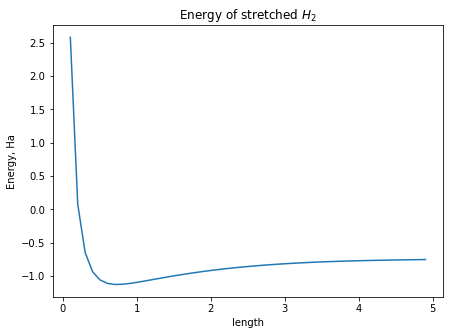

In [12]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
plt.title("Energy of stretched $H_2$")
ax.set_xlabel('length')
ax.set_ylabel('Energy, Ha')
plt.plot(np.arange(0.1, 5, 0.1), energies)
plt.show()

В случае с $He_2$, минимума быть не должно, так как в этой системе связь обеспечивается Ван-Дер-Ваальсовыми силами, которые являются дисперсионными взаимодействиями, и которые метод Хартри-Фока учесть принципиально не способен. Для их учета можно было бы воспользоваться пост-HF методами или DFT

In [13]:
energies = []
scf_steps = []
for mollen in np.arange(0.1, 5, 0.1):
    input_str = f"""
     He 0 {mollen} 0
     He 0 0 0
     """
    e, steps = calc_energy(input_str)
    energies.append(e)
    scf_steps.append(steps)

Iter=  0  E =   9.212922036061  E_diff =  9.2129e+00  D_diff =  1.6656e-14
Iter=  1  E =   9.212922036061  E_diff = -1.7764e-15  D_diff =  1.3830e-14
SCF has finished!

converged SCF energy = 9.21292203606128  <S^2> = 1.5543122e-15  2S+1 = 1
9.212922036061283
Energy matches PySCF True
Iter=  0  E =   0.235540928065  E_diff =  2.3554e-01  D_diff =  2.4112e-01
Iter=  1  E =  -0.282428483168  E_diff = -5.1797e-01  D_diff =  2.2141e-02
Iter=  2  E =  -0.284789670780  E_diff = -2.3612e-03  D_diff =  9.8108e-03
Iter=  3  E =  -0.285047766986  E_diff = -2.5810e-04  D_diff =  2.9467e-03
Iter=  4  E =  -0.285060719143  E_diff = -1.2952e-05  D_diff =  9.0340e-04
Iter=  5  E =  -0.285061757546  E_diff = -1.0384e-06  D_diff =  2.4686e-04
Iter=  6  E =  -0.285061828629  E_diff = -7.1083e-08  D_diff =  6.8979e-05
Iter=  7  E =  -0.285061833938  E_diff = -5.3096e-09  D_diff =  1.8679e-05
Iter=  8  E =  -0.285061834320  E_diff = -3.8228e-10  D_diff =  5.0895e-06
Iter=  9  E =  -0.285061834348  E_diff 

converged SCF energy = -5.47334428991852  <S^2> = 6.0919048e-11  2S+1 = 1
-5.473344289918523
Energy matches PySCF True
Iter=  0  E =  -5.219362055361  E_diff = -5.2194e+00  D_diff =  2.9285e-01
Iter=  1  E =  -5.549560170398  E_diff = -3.3020e-01  D_diff =  1.5522e-02
Iter=  2  E =  -5.550998943422  E_diff = -1.4388e-03  D_diff =  4.3552e-03
Iter=  3  E =  -5.551087057861  E_diff = -8.8114e-05  D_diff =  3.2006e-04
Iter=  4  E =  -5.551087939725  E_diff = -8.8186e-07  D_diff =  5.8898e-05
Iter=  5  E =  -5.551087973689  E_diff = -3.3965e-08  D_diff =  1.2915e-05
Iter=  6  E =  -5.551087974896  E_diff = -1.2070e-09  D_diff =  3.7902e-06
Iter=  7  E =  -5.551087974971  E_diff = -7.4644e-11  D_diff =  1.0793e-06
Iter=  8  E =  -5.551087974976  E_diff = -4.9045e-12  D_diff =  2.9738e-07
Iter=  9  E =  -5.551087974976  E_diff = -3.4284e-13  D_diff =  8.0251e-08
SCF has finished!

converged SCF energy = -5.55108797495092  <S^2> = 4.1054493e-11  2S+1 = 1
-5.551087974950924
Energy matches PySC

-5.707031219247921
Energy matches PySCF True
Iter=  0  E =  -5.481510462084  E_diff = -5.4815e+00  D_diff =  2.6131e-01
Iter=  1  E =  -5.706719519515  E_diff = -2.2521e-01  D_diff =  1.7767e-02
Iter=  2  E =  -5.708145318250  E_diff = -1.4258e-03  D_diff =  5.4875e-03
Iter=  3  E =  -5.708246345248  E_diff = -1.0103e-04  D_diff =  6.2478e-04
Iter=  4  E =  -5.708247823380  E_diff = -1.4781e-06  D_diff =  1.2595e-04
Iter=  5  E =  -5.708247877739  E_diff = -5.4359e-08  D_diff =  1.8154e-05
Iter=  6  E =  -5.708247878908  E_diff = -1.1695e-09  D_diff =  3.2518e-06
Iter=  7  E =  -5.708247878944  E_diff = -3.5969e-11  D_diff =  5.2724e-07
Iter=  8  E =  -5.708247878945  E_diff = -9.5302e-13  D_diff =  9.3630e-08
SCF has finished!

converged SCF energy = -5.7082478789438  <S^2> = 2.5122127e-12  2S+1 = 1
-5.7082478789438
Energy matches PySCF True
Iter=  0  E =  -5.482509408779  E_diff = -5.4825e+00  D_diff =  2.6118e-01
Iter=  1  E =  -5.707509991288  E_diff = -2.2500e-01  D_diff =  1.7686

-5.710319194411094
Energy matches PySCF True
Iter=  0  E =  -5.483814128766  E_diff = -5.4838e+00  D_diff =  2.6093e-01
Iter=  1  E =  -5.708824014543  E_diff = -2.2501e-01  D_diff =  1.7488e-02
Iter=  2  E =  -5.710221960832  E_diff = -1.3979e-03  D_diff =  5.3712e-03
Iter=  3  E =  -5.710320059339  E_diff = -9.8099e-05  D_diff =  5.9350e-04
Iter=  4  E =  -5.710321434479  E_diff = -1.3751e-06  D_diff =  1.1739e-04
Iter=  5  E =  -5.710321483434  E_diff = -4.8954e-08  D_diff =  1.6094e-05
Iter=  6  E =  -5.710321484405  E_diff = -9.7089e-10  D_diff =  2.7514e-06
Iter=  7  E =  -5.710321484432  E_diff = -2.7420e-11  D_diff =  4.1021e-07
Iter=  8  E =  -5.710321484433  E_diff = -6.2172e-13  D_diff =  6.6488e-08
SCF has finished!

converged SCF energy = -5.71032148443268  <S^2> = 2.4424907e-15  2S+1 = 1
-5.71032148443268
Energy matches PySCF True
Iter=  0  E =  -5.483814536870  E_diff = -5.4838e+00  D_diff =  2.6093e-01
Iter=  1  E =  -5.708824711910  E_diff = -2.2501e-01  D_diff =  1.74

-5.710320873778704
Energy matches PySCF True
Iter=  0  E =  -5.483813615601  E_diff = -5.4838e+00  D_diff =  2.6093e-01
Iter=  1  E =  -5.708823466591  E_diff = -2.2501e-01  D_diff =  1.7488e-02
Iter=  2  E =  -5.710221346154  E_diff = -1.3979e-03  D_diff =  5.3709e-03
Iter=  3  E =  -5.710319438022  E_diff = -9.8092e-05  D_diff =  5.9345e-04
Iter=  4  E =  -5.710320812947  E_diff = -1.3749e-06  D_diff =  1.1737e-04
Iter=  5  E =  -5.710320861891  E_diff = -4.8944e-08  D_diff =  1.6091e-05
Iter=  6  E =  -5.710320862862  E_diff = -9.7058e-10  D_diff =  2.7508e-06
Iter=  7  E =  -5.710320862889  E_diff = -2.7408e-11  D_diff =  4.1010e-07
Iter=  8  E =  -5.710320862890  E_diff = -6.2172e-13  D_diff =  6.6465e-08
SCF has finished!

converged SCF energy = -5.71032086288995  <S^2> = -4.4408921e-16  2S+1 = 1
-5.71032086288995
Energy matches PySCF True
Iter=  0  E =  -5.483813611146  E_diff = -5.4838e+00  D_diff =  2.6093e-01
Iter=  1  E =  -5.708823461030  E_diff = -2.2501e-01  D_diff =  1.7

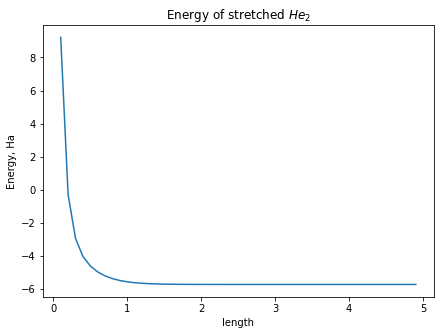

In [14]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
plt.title("Energy of stretched $He_2$")
ax.set_xlabel('length')
ax.set_ylabel('Energy, Ha')
plt.plot(np.arange(0.1, 5, 0.1), energies)
plt.show()